# Breast Cancer Classification using deep learning

## 1. Library import

In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score # for the metrics during epochs
from sklearn.model_selection import train_test_split # makes my splitting easier

## 2. Random seed for reproducibility

In [2]:
torch.manual_seed(42)
np.random.seed(42)

## 3. Paths of the images and the excel files in kagle notebook (in input)

Images from folder 1:


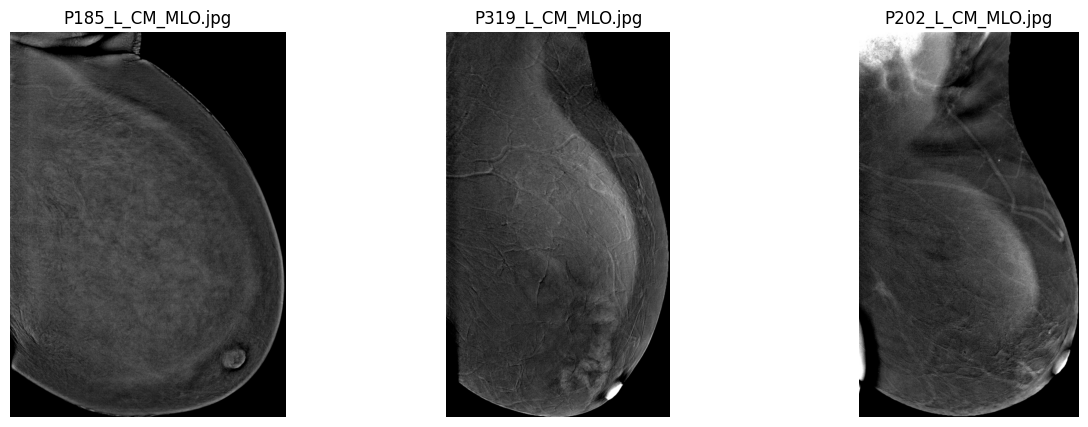

Images from folder 2:


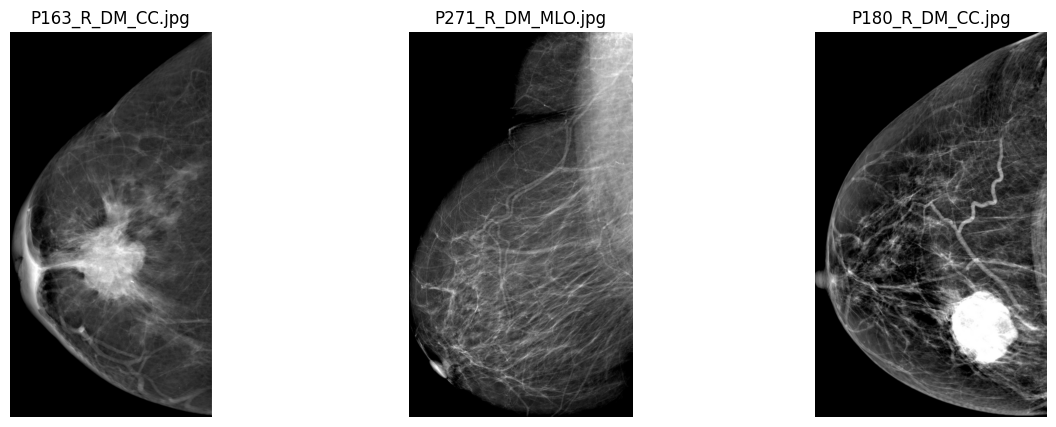

In [3]:
import random 

# Paths to the image folders
excel_path = '/kaggle/input/cdd-cesm-excel/Radiology-manual-annotations.xlsx'
image_folder1 = '/kaggle/input/pkg-cdd-cesm/PKG - CDD-CESM/CDD-CESM/Subtracted images of CDD-CESM'
image_folder2 = '/kaggle/input/pkg-cdd-cesm/PKG - CDD-CESM/CDD-CESM/Low energy images of CDD-CESM'

# Function to display images from a folder
def display_images_from_folder(folder_path, num_images=3):
    # List all files in the directory
    image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    
    #Randomly selecting the specified number of images
    selected_images = random.sample(image_files, min(num_images, len(image_files)))
    
    # Displaying the selected images
    plt.figure(figsize=(15, 5))
    for i, image_file in enumerate(selected_images):
        img_path = os.path.join(folder_path, image_file)
        img = plt.imread(img_path)
        plt.subplot(1, num_images, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(image_file)
        plt.axis('off')
    plt.show()

# Displaying 3 images from each folder
print("Images from folder 1:")
display_images_from_folder(image_folder1, num_images=3)

print("Images from folder 2:")
display_images_from_folder(image_folder2, num_images=3)

## 4. Loading the "all" spreadsheet of our data which has teh labels for our photos

In [4]:
df = pd.read_excel(excel_path, sheet_name='all')
## add a column label for the photos, normal=0, Bening/Malign=1 
df['label'] = df['Pathology Classification/ Follow up'].map({'Normal': 0, 'Benign': 1, 'Malignant': 1})
df.head(5)

,Image_name,Patient_ID,Side,Type,Age,Breast density (ACR),BIRADS,Findings,View,Tags,Machine,Pathology Classification/ Follow up,label
0,P1_L_DM_MLO,1,L,DM,46,C,4,Architectural distortion,MLO,"suspicious, distortion",1,Malignant,1
1,P1_L_CM_MLO,1,L,CESM,46,_,4,Heterogenous non mass enhancement,MLO,"suspicious, non mass",1,Malignant,1
2,P2_R_DM_CC,2,R,DM,31,C,3$2,Multiple equal density masses$Benign macrocal...,CC,"benign, masses, macrocalcification",2,Benign,1
3,P2_R_DM_MLO,2,R,DM,31,C,3$2,Multiple equal density masses$Benign macrocalc...,MLO,"benign, masses, macrocalcification",2,Benign,1
4,P2_R_CM_CC,2,R,CESM,31,_,3,Multiple homogenously enhancing masses,CC,"benign, masses, homogenous",2,Benign,1


## 5. Creating a custom dataset class  to handle the preprocessing of the images

In [5]:
class BreastCancerDataset(Dataset):
    def __init__(self, dataframe, image_folder1, image_folder2, transform=None):
        self.dataframe = dataframe
        self.image_folder1 = image_folder1
        self.image_folder2 = image_folder2
        self.transform = transform
        self.valid_indices = self._get_valid_indices()

    def _get_valid_indices(self):
        valid_indices = []
        for idx in range(len(self.dataframe)):
            img_name = self.dataframe.iloc[idx]['Image_name']
            img_path1 = os.path.join(self.image_folder1, f"{img_name}.jpg") # image is either in folder 1
            img_path2 = os.path.join(self.image_folder2, f"{img_name}.jpg") # or folder 2
            if os.path.exists(img_path1) or os.path.exists(img_path2):
                valid_indices.append(idx)
        return valid_indices

    def __len__(self):
        return len(self.valid_indices)

    # for a given index retrieving the image with the corresponding label form the daaset. Will use late for the 'Dataloader' during training
    def __getitem__(self, idx):
        real_idx = self.valid_indices[idx]
        img_name = self.dataframe.iloc[real_idx]['Image_name']
        label = self.dataframe.iloc[real_idx]['label']

        img_path1 = os.path.join(self.image_folder1, f"{img_name}.jpg")
        img_path2 = os.path.join(self.image_folder2, f"{img_name}.jpg")

        if os.path.exists(img_path1):
            image = Image.open(img_path1).convert('RGB') # to RGB coz we will do some transformation later because dataset kinda small and not balanced at all..
        elif os.path.exists(img_path2):
            image = Image.open(img_path2).convert('RGB')
        
        if self.transform:
            image = self.transform(image)

        return image, label

## 6. Image transformations 
Because we do not have very much data, and the distribution isn´t the best (more cancer pictures than normal ones) we try to transform some images to create variety during training.

In [6]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    #transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    #neu
    #transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
    #transforms.RandomAutocontrast(p=0.5),
    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## 7. Data splitting

In [7]:
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

train_df.head(5)

#val_df.head(5)

,Image_name,Patient_ID,Side,Type,Age,Breast density (ACR),BIRADS,Findings,View,Tags,Machine,Pathology Classification/ Follow up,label
271,P52_R_CM_MLO,52,R,CESM,50,_,1,No mass or non mass enhancement,MLO,normal,1,Normal,0
1067,P190_L_DM_MLO,190,L,DM,54,B,4,High density mass with speculated margin and e...,MLO,"suspicious mass, speculated, edema",1,Malignant,1
641,P115_R_DM_MLO,115,R,DM,62,C,4,Focal asymmetrical increased density with nipp...,MLO,"suspicious, focal asymmetry, edema, nipple ret...",1,Malignant,1
318,P61_L_DM_CC,61,L,DM,30,_,4,Postoperative scar and asymmetrical increased ...,CC,"postoperative, asymmetry",1,Benign,1
1453,P256_L_CM_MLO,256,L,CESM,48,_,4,Heterogenous enhacement,MLO,suspicious,1,Malignant,1


## 8: Creating Datasets and Dataloaders

In [8]:
train_dataset = BreastCancerDataset(train_df, image_folder1, image_folder2, transform=train_transform)
val_dataset = BreastCancerDataset(val_df, image_folder1, image_folder2, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

## 9/10: Some models that were tested (choose to continue with vgg16)
Efficentnet_b0 from the paper was a good Model for the 3 output case, kinda "bad" for our current 2 output cases. vgg16 was overall the best model of them all after 100 trainings.

In [9]:
# ADD OTHER MODELS IF NEEDED
def create_model(model_name):
    if model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 2)
    if model_name == 'resnet18':
        model = models.resnet18(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 2)
    elif model_name == 'densenet121':
        model = models.densenet121(pretrained=True)
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, 2)
    elif model_name == 'efficientnet_b0':
        model = models.efficientnet_b0(pretrained=True)
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, 2)
    elif model_name == 'vgg16':
        model = models.vgg16(pretrained=True)
        num_ftrs = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_ftrs, 2)
    else:
        raise ValueError(f"Unsupported model: {model_name}")
    
    return model

# 10. CHOOSE ONE MODEL THAT YOU WOULD LIKE

model = create_model('resnet18')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 48.7MB/s]


## 11. Loss function, Optimizer and the Learning Rate Scheduler

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=15, verbose=True)

## 12. Training the model with Early Stopping

We train the model until the validations set doesn´t improve for a specified number of epochs(using a patience parameter). We want to prevent overfitting in this way.

In [11]:
num_epochs = 100
best_val_f1 = 0.0
early_stopping_counter = 0
early_stopping_patience = 25 # probably make it 10,15, but impacts the accuracy often by not letting the model find its true potential, exits too soon sometimes


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = val_loss / len(val_loader)
    val_acc = val_correct / val_total
    val_f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}')

    scheduler.step(val_f1)  # we adjust the learning rate based on validation F1

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), '/kaggle/working/best_model.pth')
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= early_stopping_patience:
        print("Early stopping...")
        break
    

# Loading the best model if needed ( this can be separatte from saving)
#model.load_state_dict(torch.load('best_model.pth'))

Epoch 1/100:
Train Loss: 0.6081, Train Acc: 0.6502
Val Loss: 0.6489, Val Acc: 0.6450, Val F1: 0.5596
Epoch 2/100:
Train Loss: 0.5635, Train Acc: 0.7071
Val Loss: 0.5263, Val Acc: 0.6975, Val F1: 0.7002
Epoch 3/100:
Train Loss: 0.5360, Train Acc: 0.7171
Val Loss: 0.5132, Val Acc: 0.7200, Val F1: 0.7213
Epoch 4/100:
Train Loss: 0.4975, Train Acc: 0.7577
Val Loss: 0.4975, Val Acc: 0.7275, Val F1: 0.7239
Epoch 5/100:
Train Loss: 0.4437, Train Acc: 0.7851
Val Loss: 0.4989, Val Acc: 0.7575, Val F1: 0.7551
Epoch 6/100:
Train Loss: 0.4487, Train Acc: 0.7714
Val Loss: 0.5313, Val Acc: 0.7475, Val F1: 0.7437
Epoch 7/100:
Train Loss: 0.4435, Train Acc: 0.7964
Val Loss: 0.5148, Val Acc: 0.7375, Val F1: 0.7373
Epoch 8/100:
Train Loss: 0.4102, Train Acc: 0.8107
Val Loss: 0.5613, Val Acc: 0.7325, Val F1: 0.7364
Epoch 9/100:
Train Loss: 0.3800, Train Acc: 0.8207
Val Loss: 0.5613, Val Acc: 0.7275, Val F1: 0.7316
Epoch 10/100:
Train Loss: 0.3605, Train Acc: 0.8314
Val Loss: 0.5970, Val Acc: 0.7700, Val 

## 13. Loading the best model version

In [12]:
model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

## 14.   Evaluating the Model

calculating various metrics like F1 score (model.eval())

In [13]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

### 15. Calculating and printing our Metrics

In [14]:
cm = confusion_matrix(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
accuracy = accuracy_score(all_labels, all_preds)

print(f"Confusion Matrix:\n{cm}")
print(f"F1 Score: {f1:.4f}")
print(f"Overall Accuracy: {accuracy:.4f}")

Confusion Matrix:
[[100  51]
 [ 41 208]]
F1 Score: 0.7683
Overall Accuracy: 0.7700


### 16. Plotting the confusion matrix

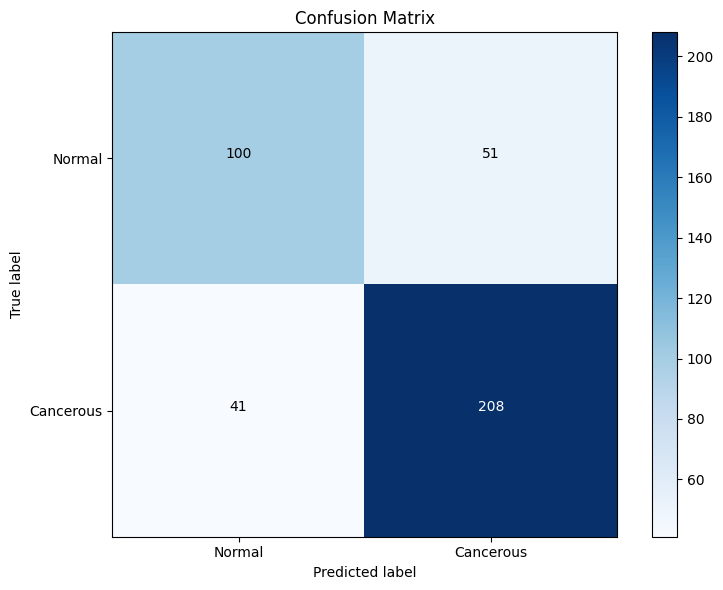

In [15]:
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Normal', 'Cancerous'])
plt.yticks(tick_marks, ['Normal', 'Cancerous'])
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

In [16]:
        torch.save(model.state_dict(), '/kaggle/working/best_model.pth')
